Source:
- https://github.com/abhinavsagar/breast-cancer-classification/blob/master/Breast_cancer_classification.ipynb

## Libraries

In [1]:
import json
import math
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import tensorflow as tf
import gc
import itertools

from PIL import Image
from functools import partial
from sklearn import metrics
from collections import Counter
from keras import backend as K
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

from keras import layers
from keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam

In [2]:
import numpy as np
import json
import utils_nn_eval
import gc
import pandas
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import cohen_kappa_score, accuracy_score

In [3]:
trained = 'gan'
tested = 'mixed'

In [4]:
figure_path = 'D:/Medical_Imaging/Medical_Imaging_Elias/Figures/train_{}/test_{}/'.format(trained, tested)

## Load Images

## Gan Images

In [5]:
benign_gan = utils_nn_eval.get_all_images('gan_benign')
malignant_gan = utils_nn_eval.get_all_images('gan_malignant')

In [6]:
print(len(benign_gan))
print(len(malignant_gan))

300
300


In [7]:
random.Random(4).shuffle(benign_gan)
random.Random(4).shuffle(malignant_gan)

### Ground Truth Images

In [8]:
benign_gt = utils_nn_eval.get_all_images('gt_benign')
malignant_gt = utils_nn_eval.get_all_images('gt_malignant')

In [9]:
print(len(benign_gt))
print(len(malignant_gt))

223
301


#### Testing

In [10]:
random.Random(4).shuffle(benign_gan)
random.Random(4).shuffle(malignant_gan)
random.Random(4).shuffle(benign_gt)
random.Random(4).shuffle(malignant_gt)

In [11]:
benign_testing_gan = benign_gan[0:150]
malignant_testing_gan = malignant_gan[0:150]
benign_testing_gt = benign_gt[0:150]
malignant_testing_gt = malignant_gt[0:150]

In [12]:
benign_testing = np.concatenate((benign_testing_gan, benign_testing_gt))
malignant_testing = np.concatenate((malignant_testing_gan, malignant_testing_gt))

In [13]:
random.Random(4).shuffle(benign_testing)
random.Random(4).shuffle(malignant_testing)

## Create Split

In [14]:
X_test, Y_test, x_train, x_val, y_train, y_val = utils_nn_eval.create_split(benign_gan, malignant_gan)

In [15]:
test_X_test, test_Y_test, test_x_train, test_x_val, test_y_train, test_y_val = utils_nn_eval.create_split(benign_testing, malignant_testing)

## Display Images

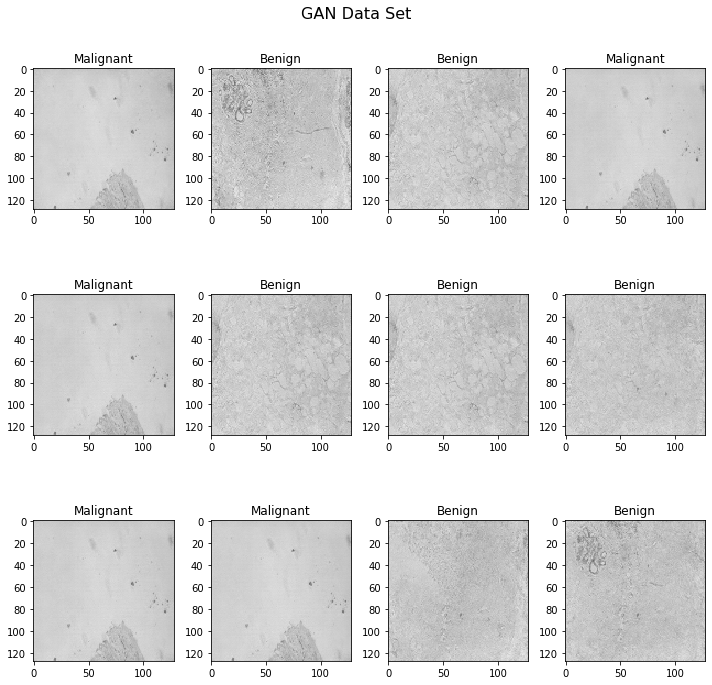

In [16]:
utils_nn_eval.display_images(x_train, y_train, "GAN Data Set")

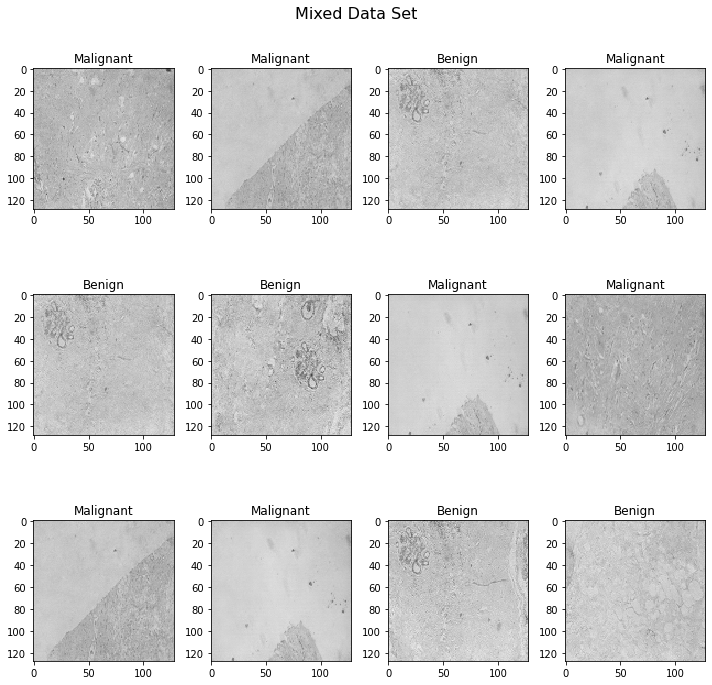

In [17]:
utils_nn_eval.display_images(test_x_train, test_y_train, "Mixed Data Set")

## Data Generator

In [18]:
train_generator = utils_nn_eval.create_train_generator()

## Model Creation

In [19]:
def build_model(backbone, lr = 1e-4):

    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation = 'softmax'))
    
    
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(learning_rate = lr),
        metrics = ['accuracy']
    )
    
    return model

In [20]:
K.clear_session()
gc.collect()

shape = (128, 128, 3)

resnet = DenseNet201(
                        weights = 'imagenet',
                        include_top = False,
                        input_shape = shape
                    )

model = build_model(resnet , lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610
No

## Prediction on Ground Truth Data

In [21]:
filepath_model = "D:/Medical_Imaging/Medical_Imaging_Elias/ResNet_DenseNet_Model/Densenet_New/models/densenet_gan_local.hdf5"
model.load_weights(filepath_model)

In [22]:
Y_val_pred = model.predict(x_val)

3/3 [==============================] - 5s 804ms/step


In [23]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

1.0

In [24]:
Y_pred = model.predict(test_X_test)

4/4 [==============================] - 6s 746ms/step


In [25]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):

    preds = model.predict_generator(train_generator.flow(test_X_test, batch_size = 16, shuffle = False),
                                            steps = len(test_X_test)/16)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis = 0)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\elias\AppData\Local\Temp/ipykernel_13884/305442214.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(train_generator.flow(test_X_test, batch_size = 16, shuffle = False),
100%|██████████| 10/10 [00:50<00:00,  5.03s/it]


## Confusion Matrix

In [26]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[58  2]
 [ 7 53]]


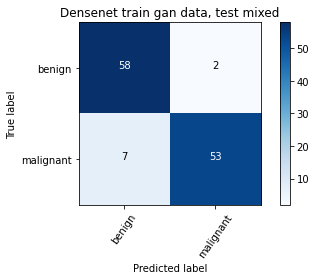

In [27]:
cm = confusion_matrix(np.argmax(test_Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label = ['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title = 'Densenet train {} data, test {}'.format(trained, tested))

Confusion matrix, without normalization
[[55  5]
 [ 6 54]]


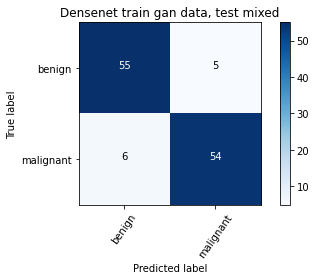

In [28]:
cm = confusion_matrix(np.argmax(test_Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label = ['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title = 'Densenet train {} data, test {}'.format(trained, tested))

## Classification Report

In [29]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(test_Y_test, axis=1), np.argmax(Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93        60
           1       0.96      0.88      0.92        60

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.92       120
weighted avg       0.93      0.93      0.92       120



In [30]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(test_Y_test, axis=1), np.argmax(Y_pred_tta, axis=1)))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91        60
           1       0.92      0.90      0.91        60

    accuracy                           0.91       120
   macro avg       0.91      0.91      0.91       120
weighted avg       0.91      0.91      0.91       120



In [31]:
report = classification_report(np.argmax(test_Y_test, axis=1), np.argmax(Y_pred, axis=1), output_dict = True)
df = pd.DataFrame(report).transpose()
df.to_csv(figure_path + "classification_report_trained_{}_test_{}_pred.csv".format(trained, tested), index = False)

## ROC and AUC

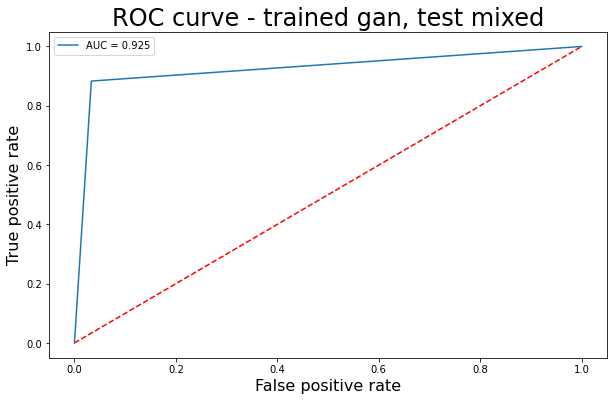

In [32]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve


roc_log = roc_auc_score(np.argmax(test_Y_test, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(test_Y_test, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.rcParams["figure.figsize"] = [10, 6]
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate', fontsize = 16)
plt.ylabel('True positive rate', fontsize = 16)
plt.title('ROC curve - trained {}, test {}'.format(trained, tested), fontsize = 24)
plt.legend(loc='best')

plt.savefig(figure_path + 'roc_auc_score_trained_{}_test_{}_pred.png'.format(trained, tested))

plt.show()
plt.close()

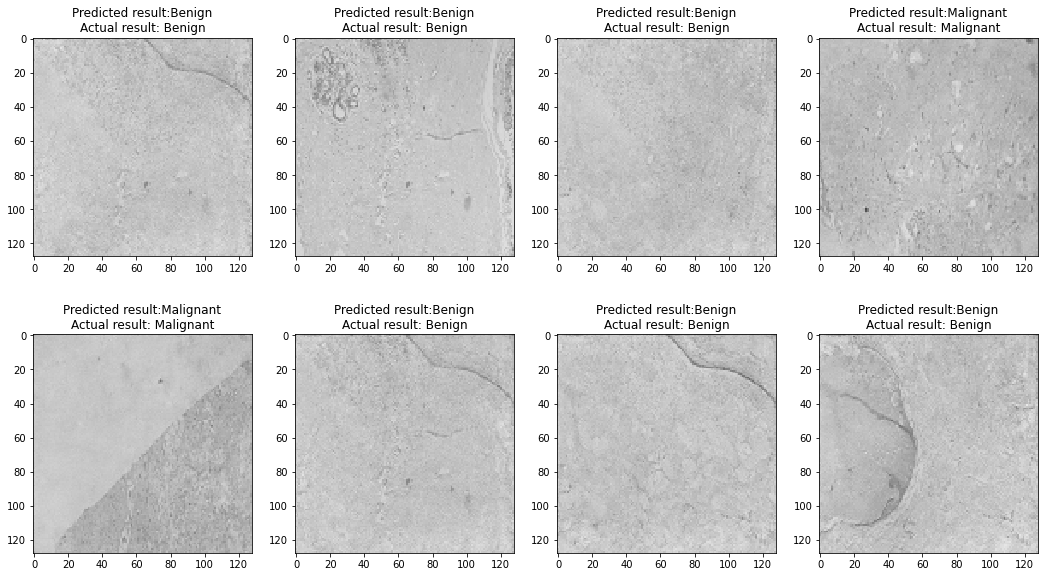

In [33]:
i = 0
prop_class=[]
mis_class=[]

for i in range(len(test_Y_test)):

    if(np.argmax(test_Y_test[i])==np.argmax(Y_pred_tta[i])):

        prop_class.append(i)

    if(len(prop_class)==8):

        break

i = 0

for i in range(len(test_Y_test)):

    if(not np.argmax(test_Y_test[i])==np.argmax(Y_pred_tta[i])):

        mis_class.append(i)

    if(len(mis_class)==8):

        break

# # Display first 8 images of benign
w = 60
h = 40
fig = plt.figure(figsize = (18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    
    if namecode==0:
    
        return "Benign"
    
    else:
    
        return "Malignant"
    
for i in range(len(prop_class)):
    
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(test_Y_test[prop_class[i]])))
    plt.imshow(test_X_test[prop_class[i]], interpolation='nearest')
    
plt.show()